In [1]:
# Load libraries
import torch
import torch.nn as nn
from res.plot_lib import set_default, show_scatterplot, plot_bases
from matplotlib.pyplot import plot, title, axis

In [2]:
# Set style (needs to be in a new cell)
set_default()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

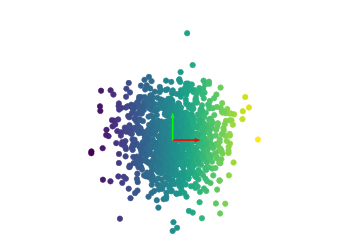

In [4]:
# generate some points in 2-D space
n_points = 1000
X = torch.randn(n_points, 2).to(device)
colors = X[:, 0]

show_scatterplot(X, colors, title='X')
OI = torch.cat((torch.zeros(2, 2), torch.eye(2))).to(device)
plot_bases(OI)

# Visualizing Linear Transformations

* Generate a random matrix $W$

$
\begin{equation}
    W = U
  \left[ {\begin{array}{cc}
   s_1 & 0 \\
   0 & s_2 \\
  \end{array} } \right]
  V^\top
\end{equation}
$
* Compute $y = Wx$
* Larger singular values stretch the points
* Smaller singular values push them together
* $U, V$ rotate/reflect

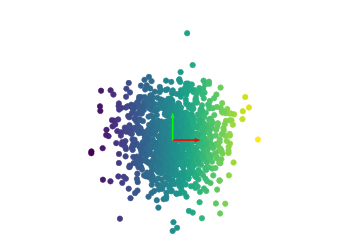

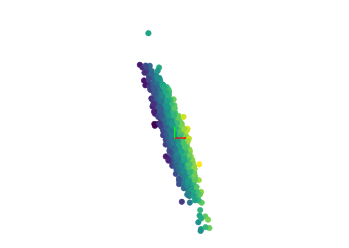

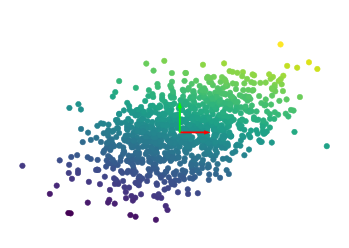

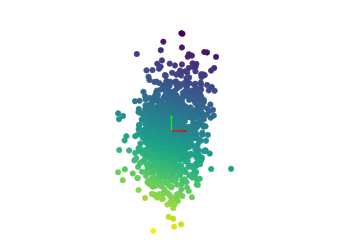

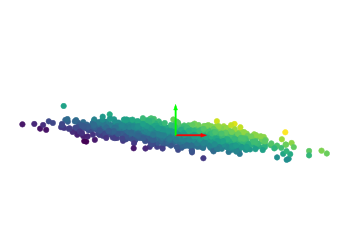

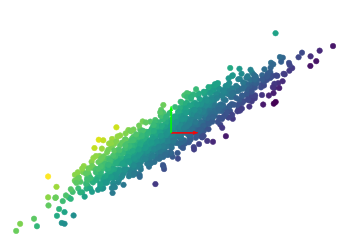

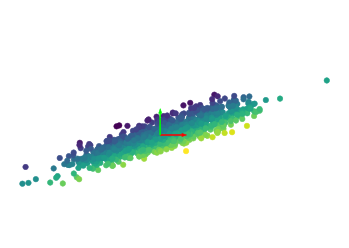

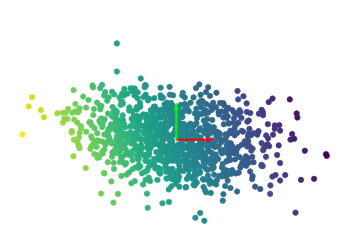

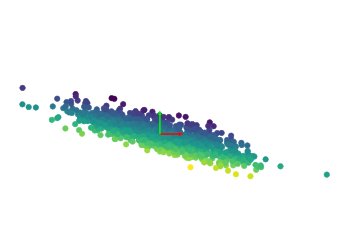

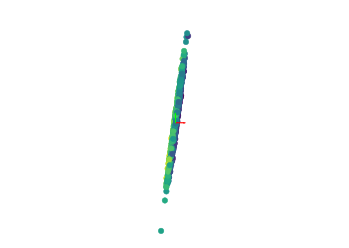

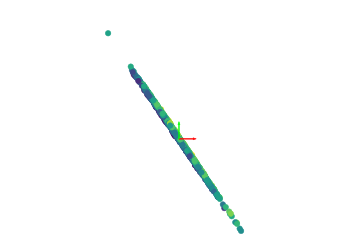

In [5]:
show_scatterplot(X, colors, title='X')
plot_bases(OI)

for i in range(10):
    # create a random matrix
    W = torch.randn(2, 2).to(device)
    # transform points
    Y = X @ W.t()
    # compute singular values
    U, S, V = torch.svd(W)
    # plot transformed points
    show_scatterplot(Y, colors, title='y = Wx, singular values : [{:.3f}, {:.3f}]'.format(S[0], S[1]))
    # transform the basis
    new_OI = OI @ W.t()
    # plot old and new basis
    plot_bases(OI)
#     plot_bases(new_OI)

# Linear transformation with PyTorch

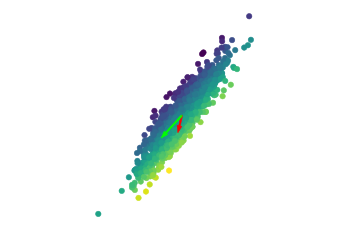

In [6]:
model = nn.Sequential(
        nn.Linear(2, 2, bias=False)
)
model.to(device)
with torch.no_grad():
    Y = model(X)
    show_scatterplot(Y, colors)
    plot_bases(model(OI))

# Non-linear Transform: Map Points to a Square

* Linear transforms can rotate, reflect, stretch and compress, but cannot curve
* We need non-linearities for this
* Can (approximately) map points to a square by first stretching out by a factor $s$, then squashing with a tanh function

$
   f(x)= \tanh \left(
  \left[ {\begin{array}{cc}
   s & 0 \\
   0 & s \\
  \end{array} } \right]  
  x
  \right)
$

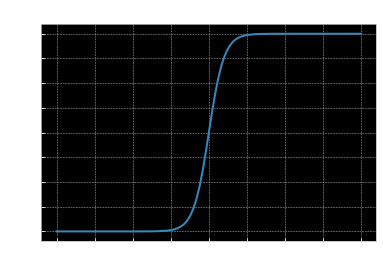

In [7]:
z = torch.linspace(-10, 10, 101)
s = torch.tanh(z)
plot(z.numpy(), s.numpy())
title('tanh() non linearity');

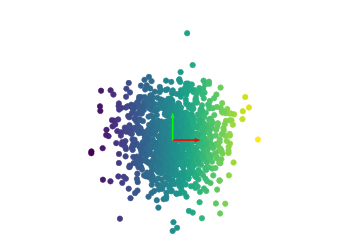

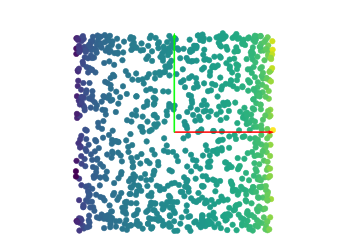

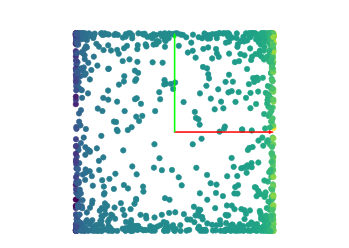

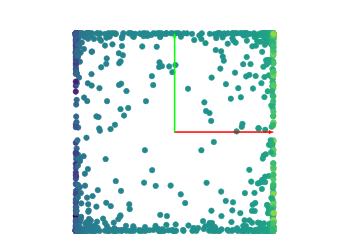

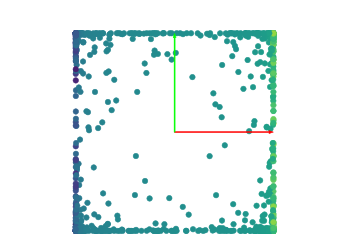

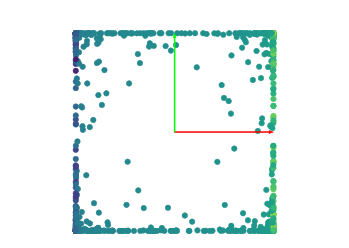

In [8]:
show_scatterplot(X, colors, title='X')
plot_bases(OI)

model = nn.Sequential(
        nn.Linear(2, 2, bias=False),
        nn.Tanh()
)

model.to(device)

for s in range(1, 6):
    W = s * torch.eye(2)
    model[0].weight.data.copy_(W)
    Y = model(X).data
    show_scatterplot(Y, colors, title=f'f(x), s={s}')
    plot_bases(OI, width=0.01)

# Visualize Functions Represented by Random Neural Networks

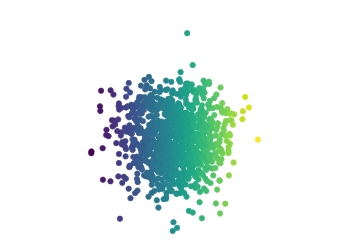

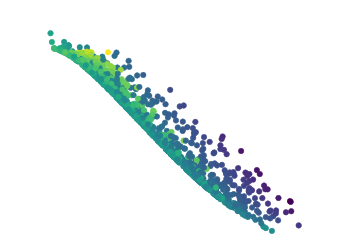

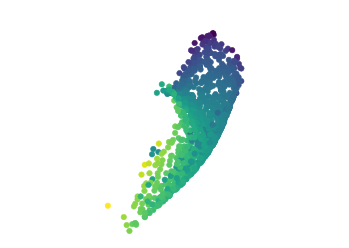

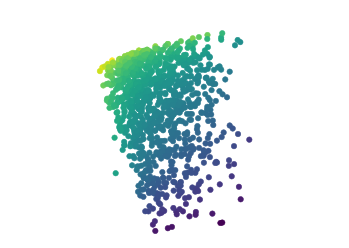

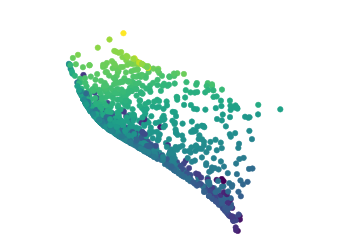

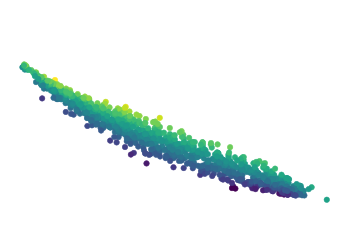

In [9]:
show_scatterplot(X, colors, title='x')
n_hidden = 5

# NL = nn.ReLU()
NL = nn.Tanh()

for i in range(5):
    # create 1-layer neural networks with random weights
    model = nn.Sequential(
            nn.Linear(2, n_hidden), 
            NL, 
            nn.Linear(n_hidden, 2)
        )
    model.to(device)
    with torch.no_grad():
        Y = model(X)
    show_scatterplot(Y, colors, title='f(x)')
#     plot_bases(OI)

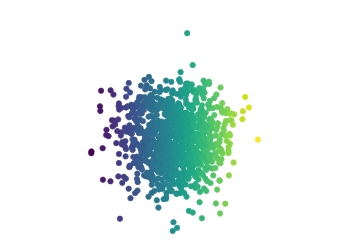

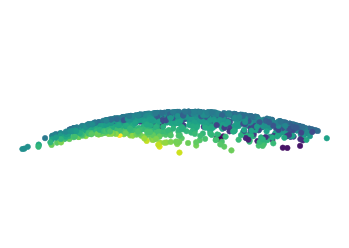

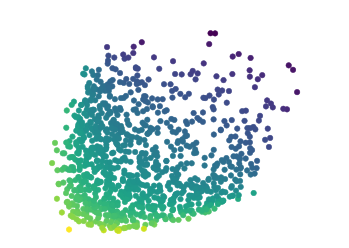

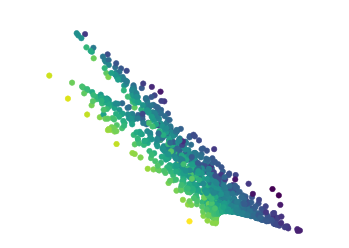

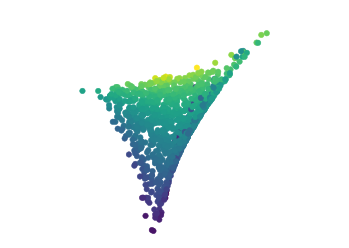

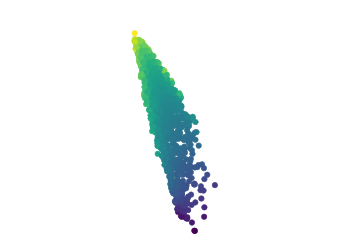

In [10]:
# deeper network with random weights
show_scatterplot(X, colors, title='x')
n_hidden = 5

# NL = nn.ReLU()
NL = nn.Tanh()

for i in range(5):
    model = nn.Sequential(
        nn.Linear(2, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, n_hidden), 
        NL, 
        nn.Linear(n_hidden, 2)
    )
    model.to(device)
    with torch.no_grad():
        Y = model(X).detach()
    show_scatterplot(Y, colors, title='f(x)')